## Causal Inference: Trying to Understand the Question of Why




Working on the IHDP dataset

In [36]:
import dowhy
from dowhy import CausalModel
from dowhy import datasets
import pandas as pd
import numpy as np
import scipy
import sklearn
import pygraphviz
import networkx
import matplotlib
import sympy
from IPython.display import Image, display

In [38]:
data= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
data.columns = col
data = data.astype({"treatment": "bool"}, copy=False)
data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


## Intervention and Outcome

The "treatment" is the intervention.

The "y_factual" is the outcome, quantified through the combination of the mental, behavioral, and health statuses of the infants. 

The x1 to x25 variables are confounders of the outcome and the intervention: variables like gender, race, quality of home-care, etc. 

We’re trying to figure out the causal relationship between the treatment and the outcome, while accounting for the confounders.

## Causal Inference with DoWhy!

DoWhy breaks down causal inference into four simple steps: model, identify, estimate, and refute. We’ll follow these steps as we perform causal inference.

## 1. Model

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['y_factual']
INFO:dowhy.causal_graph:Using Matplotlib for plotting
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


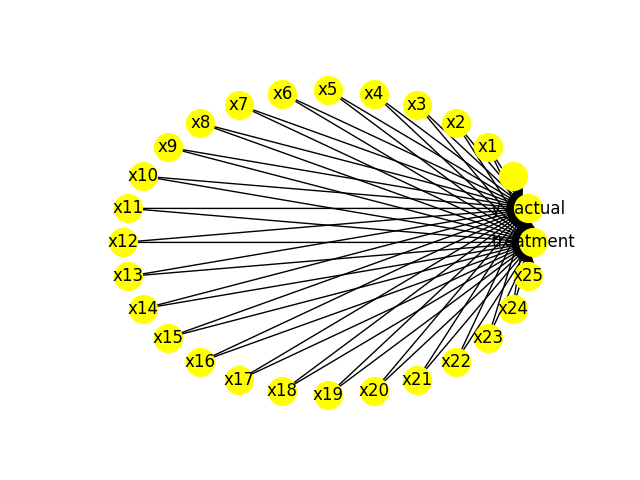

In [34]:
# Create a causal model from the data and given common causes.

x=['','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']

model=CausalModel(data = data, treatment='treatment', outcome='y_factual', common_causes=x)
model.view_model()
display(Image(filename="causal_model.png"))

#### causal_model finds the causal effect of treatment (intervention) on outcome. 

## 2. Identify

If this is an observed data (i.e., it is not from a randomized experiment), there might always be missing confounders. That is, causal effect cannot be identified perfectly.

In [20]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['', 'x25', 'x2', 'x17', 'x20', 'x19', 'x24', 'x12', 'x7', 'x8', 'x11', 'x13', 'x22', 'x21', 'x1', 'x5', 'x23', 'x18', 'x6', 'x16', 'x15', 'x10', 'x14', 'x3', 'x4', 'x9']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(y_factual|x25,x2,x17,x20,x19,x24,x12,x7,x8,x11,x13,x2
d[treatment]                                                                  

                                                 
2,x21,x1,x5,x23,x18,x6,x16,x15,x10,x14,x3,x4,x9))
                                                 
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x25,x2,x17,x20,x19,x24,x12,x7,x8,x11,x13,x22,x21,x1,x5,x23,x18,x6,x16,x15,x10,x14,x3,x4,x9,U) = P(y_factual|treatment,x25,x2,x17,x20,x19,x24,x12,x7,x8,x11,x13,x22,x21,x1,x5,x23,x18,x6,x16,x15,x10,x14,x3,x4,x9)
### Estimand : 2
Estimand name: iv
No such variable found!



## 3. Estimate

Using the estimand (the causal relationship identified) we can now estimate the strength of this causal relationship. There are many methods available to us (propensity-based-matching, additive noise modeling), but in this tutorial, we’ll stick to good old fashioned linear regression.

In [21]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x25+x2+x17+x20+x19+x24+x12+x7+x8+x11+x13+x22+x21+x1+x5+x23+x18+x6+x16+x15+x10+x14+x3+x4+x9


                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     78.91
Date:                Sun, 16 Aug 2020   Prob (F-statistic):          6.10e-191
Time:                        17:24:42   Log-Likelihood:                -1138.1
No. Observations:                 747   AIC:                             2330.
Df Residuals:                     720   BIC:                             2455.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2206      0.448      4.957      0.0

#### Let us also compute the ATE: 

ATE is not the same as the causal effect found through linear regression because it does not account for confounders.

Observational data would have unobserved confounders (factors that affect both the treatment and the outcome) or instrumental variables (factors that only affect the treatment and are thus correlated with the outcome) that ATE would not be able to account for. 

In [22]:
data_1 = data[data["treatment"]==1]
data_0 = data[data["treatment"]==0]
print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))

ATE 4.021121012430832


The number 4 doesn’t have much meaning semantically because it is the literal difference of the outcome between the two groups, and the outcome, in this case, was a combination of a variety of other factors. 
 
 
However, by taking a look back at the first 5 cases of the dataframe, one can find that the differences between (the y_factual of) the two are about 4.

## 4. Refute

The refute steps tests the strength and validity of the causal effect found by the estimate step. 

There are a variety of different refutation methods, eg. Subset Validation (using only a subset of the data to estimate the causal effect) or Placebo Treatment (turning the treatment into a placebo and seeing its effect on the outcome (the placebo treatment refutation expects the causal effect to go down).

In this case, we’ll be adding an irrelevant common cause to test the strength of the causal relationship between the treatment and outcome. This is useful because it changes the causal model but not the relationship between y_factual and treatment.

In [24]:
refute_results=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x25+x2+x17+x20+x19+x24+x12+x7+x8+x11+x13+x22+x21+x1+x5+x23+x18+x6+x16+x15+x10+x14+x3+x4+x9+w_random


                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     75.88
Date:                Sun, 16 Aug 2020   Prob (F-statistic):          5.41e-190
Time:                        17:30:56   Log-Likelihood:                -1138.1
No. Observations:                 747   AIC:                             2332.
Df Residuals:                     719   BIC:                             2462.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2219      0.448      4.955      0.0

#### Remark

Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.

Hence, we found out that there is a clear causal relationship between intervention on premature babies and their wellbeing using causal inference with DoWhy.